Dieses Notebook Erstellt die Visualisierung für den Anteil der Artefaktfenster in Abhängigkeit des Overlap Thresholds beim Labeln.

In [1]:
import sys
sys.path.append('../03 - Training')

import h5py
from utils.labeling import label_all_files

window_size_sec = 1.0
window_overlap = 0.0
overlap_tresholds = [0.99]
dir_path = "../../../../tuar_processed"
hdf5_path = "../03 - Training/features/features.hdf5"

for overlap_treshold in overlap_tresholds:
    label_generator = label_all_files(dir_path, window_size_sec, window_overlap, overlap_treshold)

    with h5py.File(hdf5_path, 'a') as hdf5_file:
        for session, label_dict in label_generator:
            session_group = hdf5_file.require_group(session)

            for channel, (data, labels) in label_dict.items():
                channel_group = session_group.require_group(channel)

                if f'labels_{overlap_treshold}_treshold' in channel_group:
                    del channel_group[f'labels_{overlap_treshold}_treshold']

                channel_group.create_dataset(f'labels_{overlap_treshold}_treshold', data=labels, compression="gzip", shuffle=True, chunks=True)

Labeling files in ../../../../tuar_processed: 0it [00:00, ?it/s]
Labeling files in ../../../../tuar_processed/train: 100%|██████████| 320/320 [00:36<00:00,  8.70it/s]
Labeling files in ../../../../tuar_processed/val: 100%|██████████| 98/98 [00:09<00:00, 10.39it/s]
Labeling files in ../../../../tuar_processed/test: 100%|██████████| 118/118 [00:12<00:00,  9.65it/s]


In [3]:
from utils.training import get_features_and_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import joblib
import numpy as np


labels = [f'labels_{threshold}_treshold' for threshold in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]]
split_test = 'test'
split_train = 'train'
feature_file = "../03 - Training/features/features.hdf5"
data_split_file = "../03 - Training/data_split.yaml"
importance_path = '../03 - Training/output/exp_03_12_feature_importance.joblib'
features = None

top_n_features = 25
importance = joblib.load(importance_path)
top_n_features_idx = np.flip(np.argsort(importance['importances_mean']))[:25]

random_state = 42
max_depth = 25
class_weight = 'balanced'

macro_f1_scores = []
non_artifact_f1_scores = []
artifact_f1_scores = []

for label in labels:
    X_train, y_train = get_features_and_labels(feature_file, features, split_train, data_split_file, label)
    X_train = X_train[:, top_n_features_idx]

    X_test, y_test = get_features_and_labels(feature_file, features, split_test, data_split_file, label)
    X_test = X_test[:, top_n_features_idx]

    clf = RandomForestClassifier(n_jobs=-1, class_weight=class_weight, max_depth=max_depth, random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    macro_f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    artifact_f1_scores.append(f1_score(y_test, y_pred))
    non_artifact_f1_scores.append(f1_score(y_test, y_pred, pos_label=0))
score_dict = {
    'macro': macro_f1_scores,
    'artifact': artifact_f1_scores,
    'non-artifact': non_artifact_f1_scores
}

joblib.dump(score_dict, 'output/exp_04_02_overlap_f1_scores.joblib')

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:02<00:00, 116.91it/s]


['output/exp_04_02_overlap_f1_scores.joblib']

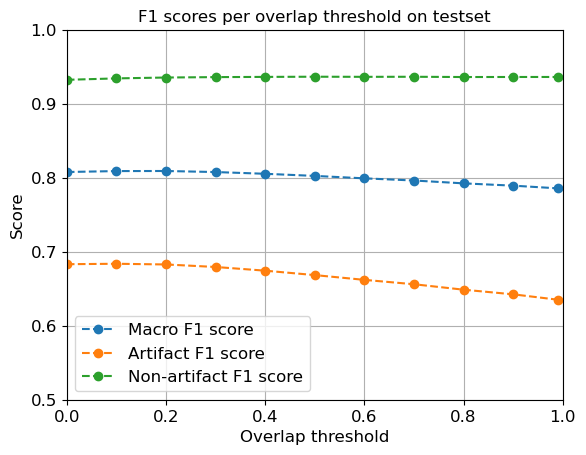

In [2]:
import joblib
from matplotlib import pyplot as plt
from matplotlib import ticker as ticker

scores_dict = joblib.load('output/exp_04_02_overlap_f1_scores.joblib')
overlaps = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

plt.plot(overlaps, scores_dict['macro'], label='Macro F1 score', marker='o', linestyle='--')
plt.plot(overlaps, scores_dict['artifact'], label='Artifact F1 score', marker='o', linestyle='--')
plt.plot(overlaps, scores_dict['non-artifact'], label='Non-artifact F1 score', marker='o', linestyle='--')
plt.xlim(0, 1)
plt.ylim(0.5, 1)
plt.grid(True)
plt.xlabel('Overlap threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('F1 scores per overlap threshold on testset', fontsize=12)
plt.legend(fontsize=12)
plt.tick_params(labelsize=12)
plt.savefig('output/exp_04_02_overlap_f1_scores.pdf', bbox_inches='tight')
plt.show()